In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Model Fitting using PyTorch

Our next topic involves some neural network models for time series. The main model that we shall look at is Recurrent Neural Networks (RNN). We shall fit these models using functions from the Python library PyTorch. This is a general optimization library that can be used to fit many models including neural networks. To illustrate how PyTorch works, let us first look at some simple examples of model fitting using PyTorch. 

## Model One: Piecewise Linear Trend Fitting

Given a time series $y_t$, suppose we want to fit the model: 
\begin{equation*}
   y_t = \beta_0 + \beta_1 t + \beta_2 (t - c_1)_+ + \dots + \beta_{k+1} (t - c_k)_+ + \epsilon_t. 
\end{equation*}
We can do this via minimizing the least squares: 
\begin{align*}
   \sum_{t=1}^n \left(y_t - \beta_0 - \beta_1 t - \beta_2 (t  - c_1)_+ - \dots - \beta_{k+1} (t - c_k)_+ \right)^2. 
\end{align*}
If $k$ is not very big, we can minimize the above without any regularization. If $k$ becomes large, then we can add either an $L_1$ or $L_2$ regularization: $\sum_{j=2}^{k+1}  \beta_j^2$ or $\sum_{j=2}^{k+1}  |\beta_j|$.


Below we use PyTorch to fit this model. Let us first import the torch libraries. 

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

The following is the code for representing the piecewise linear trend model in PyTorch. PyTorch organizes models as classes. 

In [5]:
class PiecewiseLinearModel(nn.Module):
    def __init__(self, knots_init, beta_init):
        super().__init__()
        self.num_knots = len(knots_init)
        self.beta = nn.Parameter(torch.tensor(beta_init, dtype=torch.float32)) 
        self.knots = nn.Parameter(torch.tensor(knots_init, dtype=torch.float32))

    def forward(self, x):
        knots_sorted, _ = torch.sort(self.knots)
        out = self.beta[0] + self.beta[1] * x
        for j in range(self.num_knots):
            out += self.beta[j + 2] * torch.relu(x - knots_sorted[j])
        return out

Let us apply this model to the following dataset from FRED. 

  observation_date  TTLCONS
0       1993-01-01   458080
1       1993-02-01   462967
2       1993-03-01   458399
3       1993-04-01   469425
4       1993-05-01   468998
5       1993-06-01   480247
6       1993-07-01   483571
7       1993-08-01   491494
8       1993-09-01   497297
9       1993-10-01   492823
    observation_date  TTLCONS
382       2024-11-01  2192932
383       2024-12-01  2176642
384       2025-01-01  2169595
385       2025-02-01  2165431
386       2025-03-01  2150847
387       2025-04-01  2153440
388       2025-05-01  2149124
389       2025-06-01  2160743
390       2025-07-01  2165016
391       2025-08-01  2169468


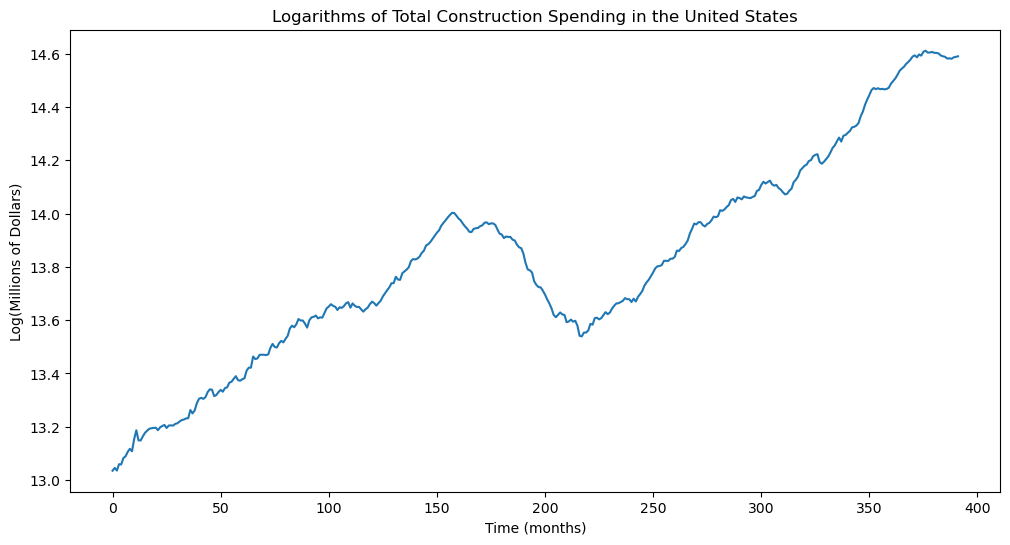

In [6]:
ttlcons = pd.read_csv('TTLCONS_17Nov2025.csv')
print(ttlcons.head(10))
print(ttlcons.tail(10))
y_raw = np.log(ttlcons['TTLCONS'])
n = len(y_raw)
x_raw = np.arange(1, n+1)
plt.figure(figsize = (12, 6))
plt.plot(y_raw)
plt.xlabel("Time (months)")
plt.ylabel('Log(Millions of Dollars)')
plt.title("Logarithms of Total Construction Spending in the United States")
plt.show()

We do not apply the model to the raw data but we scale the raw data first. The algorithm for parameter fitting will work better with scaled data as opposed to raw data. 

The code below first standardizes the raw input arrays `y_raw` and `x_raw` by subtracting their means and dividing by their standard deviations, resulting in `y_scaled` and `x_scaled`, respectively. This scaling step ensures that both inputs have mean 0 and standard deviation 1, which helps neural network training converge faster and more reliably. After scaling, the arrays are converted into PyTorch tensors (`y_torch` and `x_torch`) with `dtype=torch.float32`, and an additional singleton dimension is added using `unsqueeze(1)` to ensure each data point is treated as a one-dimensional feature vector. Conversion to PyTorch tensors is necessary because PyTorch models and optimization routines (like gradient computation and parameter updates) operate on tensors, not on NumPy arrays.

In [7]:
#Below we first scale y_raw and x_raw and then convert them to tensors for training the neural network model
y_scaled = (y_raw - np.mean(y_raw))/(np.std(y_raw))
x_scaled = (x_raw - np.mean(x_raw))/(np.std(x_raw))
y_torch = torch.tensor(y_scaled, dtype = torch.float32).unsqueeze(1)
x_torch = torch.tensor(x_scaled, dtype = torch.float32).unsqueeze(1)

We will fit the piecewise linear trend model for a fixed $k$ and use PyTorch for estimating the parameters. The first step is to obtain suitable initial estimates for the parameters. These are deduced as follows. We take $c_1, \dots, c_k$ to be quantiles of the scaled covariate at equal levels. Then we fit the model with $c_1, \dots, c_k$ fixed at these initial values, and obtain the initial values of the coefficients $\beta_2, \dots, \beta_{k+1}$. 

In [8]:
k = 6 #this is the number of knots
quantile_levels = np.linspace(1/(k+1), k/(k+1), k)
knots_init = np.quantile(x_scaled, quantile_levels)

n = len(y_scaled)
X = np.column_stack([np.ones(n), x_scaled])
for j in range(k):
    xc = ((x_scaled > knots_init[j]).astype(float))*(x_scaled-knots_init[j])  
    X = np.column_stack([X, xc])
md_init = sm.OLS(y_scaled, X).fit()
beta_init = md_init.params.values
print(knots_init)
print(beta_init)


[-1.23402709 -0.74041626 -0.24680542  0.24680542  0.74041626  1.23402709]
[ 1.0710101   1.74855865 -0.35825556  0.34626208 -4.09160644  4.7038143
 -0.94807517  0.77804141]


The next code line `md_PiecewiseLinear = PiecewiseLinearModel(knots_init=knots_init, beta_init=beta_init)` creates an instance of the custom neural network model `PiecewiseLinearModel`. It initializes the learnable parameters of the model: the knot locations are set to the values provided in `knots_init`, and the coefficients are set to `beta_init`. This prepares the model for training by defining its initial piecewise linear structure.

In [9]:
md_PiecewiseLinear = PiecewiseLinearModel(knots_init = knots_init, beta_init = beta_init)
#This code creates an instance of our custom neural network class
#It also initializes the knots at knots_init

The next block of code sets up and runs the training loop for the `PiecewiseLinearModel`. The `Adam` optimizer is initialized with the model’s parameters and a learning rate of 0.01, and the loss function is set to mean squared error (`MSELoss`). For 20,000 epochs, the code repeatedly performs one training step: it clears previous gradients with `optimizer.zero_grad()`, computes predictions `y_pred` by passing `x_torch` through the model, evaluates the loss between predictions and true values, backpropagates the loss with `loss.backward()`, and updates the model parameters using `optimizer.step()`. Every 100 epochs, the current epoch and loss value are printed to monitor training progress. Running the code multiple times may be necessary to ensure good convergence, especially for non-convex optimization problems.

In [10]:
optimizer = optim.Adam(md_PiecewiseLinear.parameters(), lr = 0.01) 
#the above line tells Python to create an Adam optimizer that will update all parameters of md_PiecewiseLinear during training, using a learning rate of 0.01. 
loss_fn = nn.MSELoss()

for epoch in range(20000): 
    optimizer.zero_grad()
    y_pred = md_PiecewiseLinear(x_torch)
    loss = loss_fn(y_pred, y_torch)
    loss.backward() #calulates gradients
    optimizer.step() #updates parameters using gradients
    if epoch % 100 == 0: 
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
#Run this code a few times to be sure of convergence. 

Epoch 0, Loss: 0.0079
Epoch 100, Loss: 0.0062
Epoch 200, Loss: 0.0059
Epoch 300, Loss: 0.0057
Epoch 400, Loss: 0.0056
Epoch 500, Loss: 0.0055
Epoch 600, Loss: 0.0054
Epoch 700, Loss: 0.0053
Epoch 800, Loss: 0.0053
Epoch 900, Loss: 0.0052
Epoch 1000, Loss: 0.0052
Epoch 1100, Loss: 0.0051
Epoch 1200, Loss: 0.0051
Epoch 1300, Loss: 0.0051
Epoch 1400, Loss: 0.0051
Epoch 1500, Loss: 0.0050
Epoch 1600, Loss: 0.0050
Epoch 1700, Loss: 0.0050
Epoch 1800, Loss: 0.0050
Epoch 1900, Loss: 0.0050
Epoch 2000, Loss: 0.0050
Epoch 2100, Loss: 0.0050
Epoch 2200, Loss: 0.0050
Epoch 2300, Loss: 0.0050
Epoch 2400, Loss: 0.0049
Epoch 2500, Loss: 0.0049
Epoch 2600, Loss: 0.0049
Epoch 2700, Loss: 0.0052
Epoch 2800, Loss: 0.0049
Epoch 2900, Loss: 0.0049
Epoch 3000, Loss: 0.0049
Epoch 3100, Loss: 0.0049
Epoch 3200, Loss: 0.0049
Epoch 3300, Loss: 0.0049
Epoch 3400, Loss: 0.0049
Epoch 3500, Loss: 0.0049
Epoch 3600, Loss: 0.0049
Epoch 3700, Loss: 0.0049
Epoch 3800, Loss: 0.0049
Epoch 3900, Loss: 0.0049
Epoch 4000, 

The next code prints out the current loss value, the estimated model coefficients (`beta`), and the estimated knot locations after training. The `detach().numpy()` calls are used to move each tensor from the computation graph to a regular NumPy array so they can be easily printed or further processed without tracking gradients. 


In [11]:
print(loss.detach().numpy())
print(md_PiecewiseLinear.beta.detach().numpy())
print(md_PiecewiseLinear.knots.detach().numpy())


0.0047988915
[ 0.99718404  1.7058834  -1.6600022   2.086846   -5.034503    5.0382504
 -1.4400616   1.3958895 ]
[-0.84136385 -0.69282526 -0.2414546   0.19208266  0.81079537  1.0259839 ]


The next code computes the model’s fitted values by passing `x_torch` through the trained `PiecewiseLinearModel` and applying `.detach().numpy()` to convert the output tensor into a NumPy array, which disconnects it from the PyTorch computation graph. The fitted values (`nn_fits`) represent the model’s predicted outputs on the training data and are printed for inspection.


In [12]:
fitvals = md_PiecewiseLinear(x_torch).detach().numpy()
fitvals_original_scale = (fitvals * np.std(y_raw)) + np.mean(y_raw)

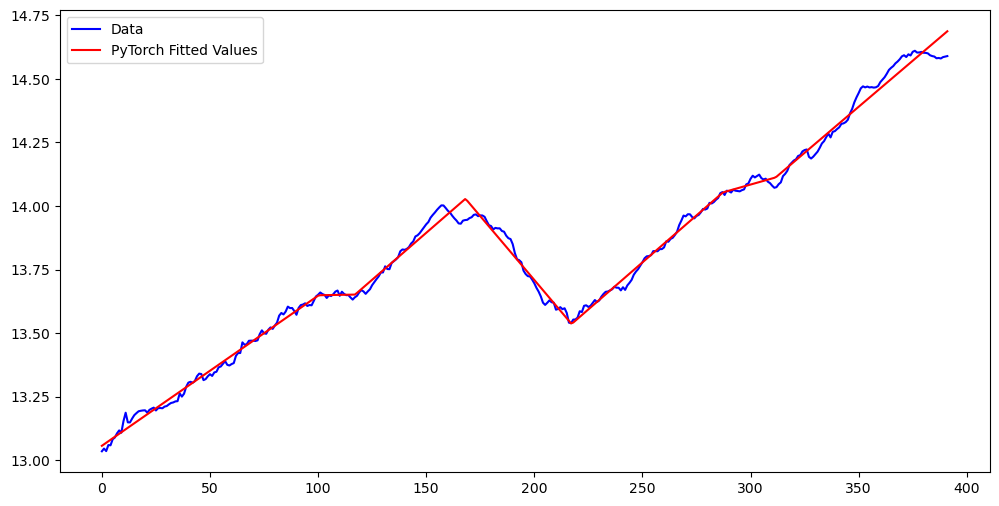

In [13]:
plt.figure(figsize = (12, 6))
plt.plot(y_raw, color = 'blue', label = 'Data')
plt.plot(fitvals_original_scale, color = 'red', label = 'PyTorch Fitted Values')
plt.legend()
plt.show()

## Adding a Regularizer

Suppose we increase the number of knots (go back to the previous code and increase $k$ say to 50). Then the fitted values will resemble the actual data i.e., we will overfit. To fix overfitting, we can employ  regularization. 

In [14]:
k = 50 #this is the number of knots
quantile_levels = np.linspace(1/(k+1), k/(k+1), k)
knots_init = np.quantile(x_scaled, quantile_levels)

n = len(y_scaled)
X = np.column_stack([np.ones(n), x_scaled])
for j in range(k):
    xc = ((x_scaled > knots_init[j]).astype(float))*(x_scaled-knots_init[j])  
    X = np.column_stack([X, xc])
md_init = sm.OLS(y_scaled, X).fit()
beta_init = md_init.params.values
print(knots_init)
print(beta_init)


[-1.65988742 -1.59213692 -1.52438641 -1.4566359  -1.3888854  -1.32113489
 -1.25338438 -1.18563387 -1.11788337 -1.05013286 -0.98238235 -0.91463185
 -0.84688134 -0.77913083 -0.71138032 -0.64362982 -0.57587931 -0.5081288
 -0.4403783  -0.37262779 -0.30487728 -0.23712677 -0.16937627 -0.10162576
 -0.03387525  0.03387525  0.10162576  0.16937627  0.23712677  0.30487728
  0.37262779  0.4403783   0.5081288   0.57587931  0.64362982  0.71138032
  0.77913083  0.84688134  0.91463185  0.98238235  1.05013286  1.11788337
  1.18563387  1.25338438  1.32113489  1.3888854   1.4566359   1.52438641
  1.59213692  1.65988742]
[ 3.70479589  3.31920328 -0.61975363 -2.12706708 -0.23358562  2.23215961
 -0.56357887 -1.18544788  0.9441146   1.09234493 -1.82968666  2.13420425
 -2.74675755  1.25348588 -1.03545406 -1.23588121  1.39025268  2.2545587
 -0.53448749 -0.13166522  1.67493038 -4.31556708 -1.06919549  2.09639669
 -2.63356884 -1.71921202 -1.14300924  2.02097122  0.79213502  2.42831366
  1.81811678 -1.14015569  0

In [15]:
md_large_k = PiecewiseLinearModel(knots_init = knots_init, beta_init = beta_init)

As we have seen previously, natural regularizers here are $\lambda \sum_{j=2}^{k+1} |\beta_j|$ or $\lambda \sum_{j=2}^{k+1} \beta_j^2$ ($\lambda$ needs to be chosen carefully). 

In [16]:
#Adding a regularizer to the loss function.
optimizer = optim.Adam(md_large_k.parameters(), lr = 0.01)
loss_fn = nn.MSELoss()
lambda_l1 = 0.0007 #this works pretty well
#lambda_l2 = .002

for epoch in range(10000): 
    optimizer.zero_grad()
    y_pred = md_large_k(x_torch)
    mse_loss = loss_fn(y_pred, y_torch)
    l1_penalty = torch.norm(md_large_k.beta[2:], p = 1) 
    #l2_penalty = torch.sum(md_large_k.beta[2:] ** 2)
    loss = mse_loss + lambda_l1 * l1_penalty
    #loss = mse_loss + lambda_l2 * l2_penalty
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0: 
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
#Run this code a few times to be sure of convergence. 

Epoch 0, Loss: 0.0676
Epoch 100, Loss: 0.0663
Epoch 200, Loss: 0.0652
Epoch 300, Loss: 0.0640
Epoch 400, Loss: 0.0627
Epoch 500, Loss: 0.0614
Epoch 600, Loss: 0.0601
Epoch 700, Loss: 0.0587
Epoch 800, Loss: 0.0571
Epoch 900, Loss: 0.0556
Epoch 1000, Loss: 0.0540
Epoch 1100, Loss: 0.0526
Epoch 1200, Loss: 0.0513
Epoch 1300, Loss: 0.0498
Epoch 1400, Loss: 0.0485
Epoch 1500, Loss: 0.0474
Epoch 1600, Loss: 0.0464
Epoch 1700, Loss: 0.0454
Epoch 1800, Loss: 0.0446
Epoch 1900, Loss: 0.0438
Epoch 2000, Loss: 0.0425
Epoch 2100, Loss: 0.0416
Epoch 2200, Loss: 0.0409
Epoch 2300, Loss: 0.0401
Epoch 2400, Loss: 0.0393
Epoch 2500, Loss: 0.0385
Epoch 2600, Loss: 0.0376
Epoch 2700, Loss: 0.0369
Epoch 2800, Loss: 0.0361
Epoch 2900, Loss: 0.0353
Epoch 3000, Loss: 0.0345
Epoch 3100, Loss: 0.0346
Epoch 3200, Loss: 0.0333
Epoch 3300, Loss: 0.0322
Epoch 3400, Loss: 0.0315
Epoch 3500, Loss: 0.0317
Epoch 3600, Loss: 0.0304
Epoch 3700, Loss: 0.0301
Epoch 3800, Loss: 0.0295
Epoch 3900, Loss: 0.0298
Epoch 4000, 

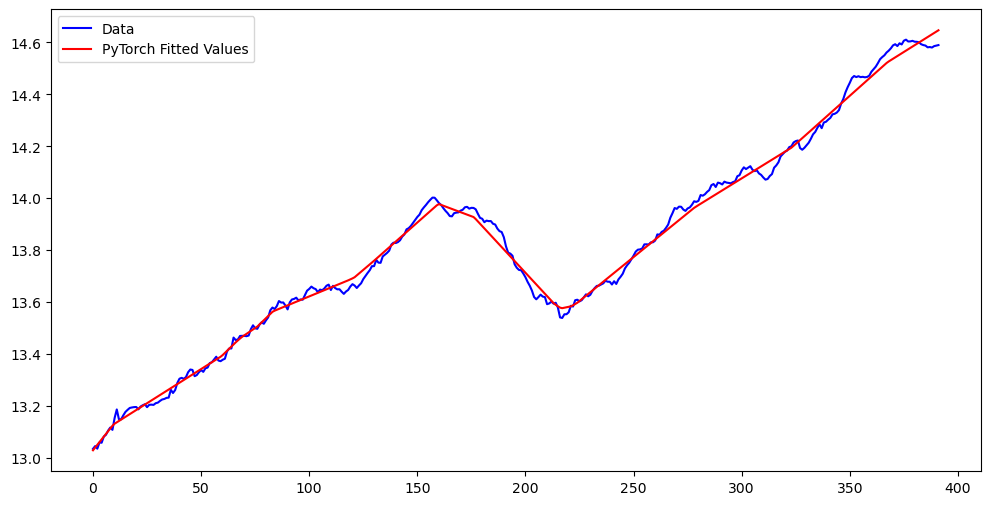

In [17]:
fitvals = md_large_k(x_torch).detach().numpy()
fitvals_original_scale = (fitvals * np.std(y_raw)) + np.mean(y_raw)
plt.figure(figsize = (12, 6))
plt.plot(y_raw, color = 'blue', label = 'Data')
plt.plot(fitvals_original_scale, color = 'red', label = 'PyTorch Fitted Values')
plt.legend()
plt.show()

## MA(1) and AR(1) model fitting via PyTorch

### MA(1) model fitting

The algorithms from PyTorch can also be used to fit classical time series models. Here we illustrate how to fit MA(1) and AR(1) models. We will use the varve dataset from Lecture 21. 

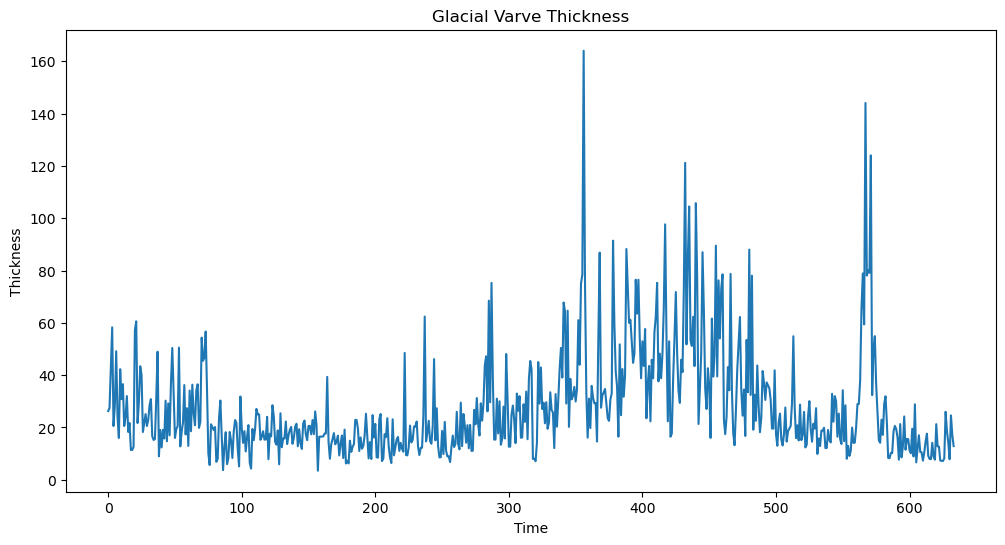

In [168]:
varve_data = pd.read_csv("varve.csv")
yraw = varve_data['x']
plt.figure(figsize = (12, 6))
plt.plot(yraw)
plt.xlabel('Time')
plt.ylabel('Thickness')
plt.title('Glacial Varve Thickness')
plt.show()

In Lecture 20, we took logarithms of this dataset, then differenced, and then fitted the MA(1) model. We will now fit this model (as well as AR(1)) using PyTorch (instead of ARIMA).  First let us recall how we fit this using the ARIMA function. 

In [169]:
from statsmodels.tsa.arima.model import ARIMA
ylogdiff = np.diff(np.log(yraw))
mamod_ARIMA = ARIMA(ylogdiff, order = (0, 0, 1)).fit()
print(mamod_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  633
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -440.678
Date:                Tue, 25 Nov 2025   AIC                            887.356
Time:                        16:16:54   BIC                            900.707
Sample:                             0   HQIC                           892.541
                                - 633                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.004     -0.280      0.779      -0.010       0.008
ma.L1         -0.7710      0.023    -33.056      0.000      -0.817      -0.725
sigma2         0.2353      0.012     18.881      0.0

We next fit the MA(1) model using PyTorch. Below we describe the optimization problem that we need to solve in order to estimate the MA(1) parameters $\mu, \theta, \sigma$. Recall that the MA(1) model is given by
\begin{equation*}
  y_t = \mu + \epsilon_t + \theta \epsilon_{t-1}
\end{equation*}
with $\epsilon_t \overset{\text{i.i.d}}{\sim} N(0, \sigma^2)$. The likelihood is $f_{y_1, \dots, y_n}(y_1, \dots, y_n)$ can be written in terms of the covariance matrix of $y_1, \dots, y_n$. This is somewhat complicated. A simplification trick is to condition on $\epsilon = 0$ i.e., one attempts to write the conditional likelihood: 
\begin{equation*}
   f_{y_1, \dots, y_n \mid \epsilon_0 = 0}(y_1, \dots, y_n). 
\end{equation*}
This likelihood is much simpler to write by breaking it down as
\begin{equation*}
  f_{y_1 \mid \epsilon_0 = 0}(y_1) f_{y_2 \mid y_1, \epsilon_0 = 0}(y_2) f_{y_3 \mid y_1, y_2, \epsilon_0 = 0}(y_3) \dots f_{y_n \mid y_1, \dots, y_{n-1}, \epsilon_0 = 0}(y_n)
\end{equation*}
Each of the terms above can be written explicitly. Let $\hat{\epsilon}_1 = y_1 - \mu$ and, for $t = 2, \dots, n$, 
\begin{equation*}
    \hat{\epsilon}_t = y_t- \mu - \theta \hat{\epsilon}_{t-1} 
\end{equation*}
Then 
\begin{equation*}
   f_{y_1 \mid \epsilon_0 = 0}(y_1) = \frac{1}{\sqrt{2 \pi} \sigma} \exp \left(-\frac{(y_1 - \mu)^2}{2 \sigma^2} \right)
\end{equation*}
and
\begin{align*}
  f_{y_t \mid y_1, \dots, y_{t-1}, \epsilon = 0}(y_t) &= f_{y_t \mid \epsilon_1 = \hat{\epsilon}_1, \epsilon_2 = \hat{\epsilon}_2, \dots, \epsilon_{t-1} = \hat{\epsilon}_{t-1}, \epsilon_0 = 0}(y_t) \\
  &= f_{\epsilon_t}(y_t - \mu - \theta \hat{\epsilon}_{t-1}) = \frac{1}{\sqrt{2 \pi} \sigma} \exp \left(-\frac{1}{2 \sigma^2} (y_t - \mu - \theta \hat{\epsilon}_{t-1})^2 \right). 
\end{align*}
Thus the conditional likelihood given $\epsilon_0 = 0$ is given by
\begin{align*}
   \frac{1}{\sqrt{2 \pi} \sigma} \exp \left(-\frac{(y_1 - \mu)^2}{2 \sigma^2} \right) \left[\prod_{t=2}^n \frac{1}{\sqrt{2 \pi} \sigma} \exp \left(-\frac{1}{2 \sigma^2} (y_t - \mu - \theta \hat{\epsilon}_{t-1})^2 \right) \right] = \frac{1}{\sqrt{2 \pi} \sigma} \exp \left(-\frac{\hat{\epsilon}_1^2}{2 \sigma^2} \right) \left[\prod_{t=2}^n \frac{1}{\sqrt{2 \pi} \sigma} \exp \left(-\frac{\hat{\epsilon}_t^2}{2 \sigma^2}  \right) \right]
\end{align*}
so that the negative log-likelihood  becomes:
\begin{align*}
   \frac{n}{2} \log (2 \pi) + 0.5 \sum_{t=1}^n \left(\log \sigma^2 + \frac{\hat{\epsilon}_t^2}{\sigma^2} \right). 
\end{align*}


In [167]:
class MA1Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.mu = nn.Parameter(torch.tensor(0.0)) #initialized at 0
        self.theta = nn.Parameter(torch.tensor(0.0)) #initialized at 0
        self.log_sigma = nn.Parameter(torch.tensor(0.0))  # log(sigma)

    def forward(self, y): #this function computes the negative log-likelihood given data y
        n = len(y)
        eps_list = []
        eps_prev = y[0] - self.mu  # ε_0
        eps_list.append(eps_prev)
        for t in range(1, n):
            eps_t = y[t] - self.mu - self.theta * eps_prev
            eps_list.append(eps_t)
            eps_prev = eps_t  
        eps = torch.stack(eps_list)
        sigma = torch.exp(self.log_sigma)
        nll = (0.5 * n * np.log(2 * np.pi)) + 0.5 * torch.sum(torch.log(sigma**2) + (eps**2) / (sigma**2))
        return nll

In [170]:
ylogdiff_tensor = torch.tensor(ylogdiff, dtype = torch.float32) 
mamod = MA1Model()
optimizer = optim.Adam(mamod.parameters(), lr=0.001)
for epoch in range(4000):
    optimizer.zero_grad()
    loss = mamod(ylogdiff_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        sigma = torch.exp(mamod.log_sigma).item()
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, mu: {mamod.mu.item():.4f}, "
              f"theta: {mamod.theta.item():.4f}, sigma: {sigma:.4f}")


Epoch 0, Loss: 686.6678, mu: -0.0010, theta: -0.0010, sigma: 0.9990
Epoch 100, Loss: 637.9557, mu: -0.0011, theta: -0.1006, sigma: 0.9050
Epoch 200, Loss: 593.8228, mu: -0.0011, theta: -0.1994, sigma: 0.8229
Epoch 300, Loss: 554.7609, mu: -0.0010, theta: -0.2977, sigma: 0.7518
Epoch 400, Loss: 521.1600, mu: -0.0011, theta: -0.3950, sigma: 0.6909
Epoch 500, Loss: 493.3359, mu: -0.0010, theta: -0.4902, sigma: 0.6394
Epoch 600, Loss: 471.5910, mu: -0.0010, theta: -0.5805, sigma: 0.5968
Epoch 700, Loss: 456.2417, mu: -0.0011, theta: -0.6599, sigma: 0.5624
Epoch 800, Loss: 447.1696, mu: -0.0011, theta: -0.7199, sigma: 0.5359
Epoch 900, Loss: 442.9311, mu: -0.0011, theta: -0.7544, sigma: 0.5167
Epoch 1000, Loss: 441.2652, mu: -0.0011, theta: -0.7682, sigma: 0.5038
Epoch 1100, Loss: 440.6577, mu: -0.0012, theta: -0.7719, sigma: 0.4956
Epoch 1200, Loss: 440.4542, mu: -0.0012, theta: -0.7727, sigma: 0.4907
Epoch 1300, Loss: 440.3933, mu: -0.0011, theta: -0.7728, sigma: 0.4880
Epoch 1400, Loss: 

The following code prints out the estimates given by this code, along with the estimates given by the ARIMA function. 

In [171]:
ma1_pars = np.array([mamod.mu.detach().numpy(), mamod.theta.detach().numpy(), np.exp(2*mamod.log_sigma.detach().numpy())]) #mu, theta and sigma^2
print(np.column_stack([mamod_ARIMA.params, ma1_pars]))
#the parameter estimates are quite close to each other

[[-0.00125667 -0.0011363 ]
 [-0.77099236 -0.77283096]
 [ 0.23528045  0.23539422]]


### AR(1) model fitting

Next let us fit the AR(1) model using PyTorch. Note that the full likelihood in the AR(1) model (stationary case) is given by (see Equation (7) in the notes for Lecture 17): 
\begin{align*}
\frac{\sqrt{1 - \phi_1^2}}{\sqrt{2 \pi}
      \sigma} \exp \left(-\frac{1 - \phi_1^2}{2 \sigma^2} \left(y_1 -
        \frac{\phi_0}{1 - \phi_1} \right)^2 \right) \left(\frac{1}{\sqrt{2 \pi} \sigma}
    \right)^{n-1} \exp \left(-\frac{1}{2 \sigma^2} \sum_{t=2}^n (y_t -
    \phi_0 - \phi_1 y_{t-1})^2 \right). 
\end{align*}
Below we first fit AR(1) using ARIMA, and then fit it by maximizing the log of the likelihood written above. 


In [172]:
armod_ARIMA = ARIMA(ylogdiff, order = (1, 0, 0)).fit()
print(armod_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  633
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -494.562
Date:                Tue, 25 Nov 2025   AIC                            995.124
Time:                        16:20:33   BIC                           1008.475
Sample:                             0   HQIC                          1000.309
                                - 633                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.015     -0.067      0.946      -0.031       0.029
ar.L1         -0.3970      0.036    -10.989      0.000      -0.468      -0.326
sigma2         0.2793      0.015     18.916      0.0

In [173]:
class AR1Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Learnable parameters: phi0 (intercept), phi1 (AR coefficient), log_sigma (for positivity)
        self.phi0 = nn.Parameter(torch.tensor(0.0))
        self.phi1 = nn.Parameter(torch.tensor(0.0))
        self.log_sigma = nn.Parameter(torch.tensor(0.0))  # log(sigma) to ensure sigma > 0

    def forward(self, y):
        n = len(y)
        sigma = torch.exp(self.log_sigma)
        phi0 = self.phi0
        phi1 = self.phi1
        #If the model is non-stationary, return infinite negative log-likelihood (and None for log-likelihood)
        if torch.abs(phi1) >= 1:
            return torch.tensor(float("inf")), None

        # Stationary mean of y_1
        y1_mean = phi0 / (1 - phi1)

        # Compute log-likelihood parts
        part1 = -0.5 * n * torch.log(torch.tensor(2 * torch.pi))
        part2 = -n * torch.log(sigma)
        part3 = 0.5 * torch.log(1 - phi1**2)
        part4 = - (1 - phi1**2) / (2 * sigma**2) * (y[0] - y1_mean)**2
        part5 = - (1 / (2 * sigma**2)) * torch.sum((y[1:] - phi0 - phi1 * y[:-1])**2)

        log_likelihood = part1 + part2 + part3 + part4 + part5
        negative_log_likelihood = -log_likelihood  # because we minimize

        return negative_log_likelihood, log_likelihood


In [174]:
# Fit the model
armod = AR1Model()
optimizer = optim.Adam(armod.parameters(), lr=0.001)

for epoch in range(4000):
    loss, loglike = armod(ylogdiff_tensor)
    optimizer.zero_grad() #removes previously calculated gradients
    loss.backward() #calculates gradients
    optimizer.step() #updates parameters using gradients
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: phi0={armod.phi0.item():.4f}, phi1={armod.phi1.item():.4f}, sigma={torch.exp(armod.log_sigma).item():.4f}, loss={loss.item():.4f}")

Epoch 0: phi0=-0.0010, phi1=-0.0010, sigma=0.9990, loss=686.6678
Epoch 100: phi0=-0.0012, phi1=-0.0996, sigma=0.9050, loss=638.2626
Epoch 200: phi0=-0.0013, phi1=-0.1913, sigma=0.8231, loss=595.9210
Epoch 300: phi0=-0.0013, phi1=-0.2703, sigma=0.7529, loss=561.3080
Epoch 400: phi0=-0.0014, phi1=-0.3307, sigma=0.6942, loss=535.2979
Epoch 500: phi0=-0.0014, phi1=-0.3691, sigma=0.6464, loss=517.4683
Epoch 600: phi0=-0.0014, phi1=-0.3880, sigma=0.6091, loss=506.3111
Epoch 700: phi0=-0.0014, phi1=-0.3948, sigma=0.5812, loss=499.9816
Epoch 800: phi0=-0.0014, phi1=-0.3965, sigma=0.5612, loss=496.7854
Epoch 900: phi0=-0.0014, phi1=-0.3969, sigma=0.5478, loss=495.3693
Epoch 1000: phi0=-0.0014, phi1=-0.3969, sigma=0.5393, loss=494.8214
Epoch 1100: phi0=-0.0014, phi1=-0.3969, sigma=0.5342, loss=494.6358
Epoch 1200: phi0=-0.0014, phi1=-0.3970, sigma=0.5313, loss=494.5806
Epoch 1300: phi0=-0.0014, phi1=-0.3970, sigma=0.5298, loss=494.5661
Epoch 1400: phi0=-0.0014, phi1=-0.3970, sigma=0.5291, loss=4

In [175]:
ar1_pars = np.array([armod.phi0.detach().numpy(), armod.phi1.detach().numpy(), np.exp(2*armod.log_sigma.detach().numpy())]) #mu, theta and sigma^2
print(np.column_stack([armod_ARIMA.params, ar1_pars]))

[[-0.00102183 -0.00142138]
 [-0.39696193 -0.39696237]
 [ 0.27927876  0.27927739]]


It is possible to extend these methods to fit AR($p$) and MA($q$) for more general $p$ and $q$ using PyTorch. The PyTorch method seems to work just as well as ARIMA. Note that the AR code works much faster than the MA code. This is because the it takes longer to write the likelihood for the MA model comapared to the AR model.  

## Nonlinear AutoRegression

### Example One

We fit the NonLinear AR(1) model to a simulated dataset generated using the following equation: 
\begin{equation*}
   y_t = \frac{2 y_{t-1}}{1 + 0.8 y_{t-1}^2} + \epsilon_t
\end{equation*}
where $\epsilon_t \overset{\text{i.i.d}}{\sim} \text{uniform}(-1, 1)$. 

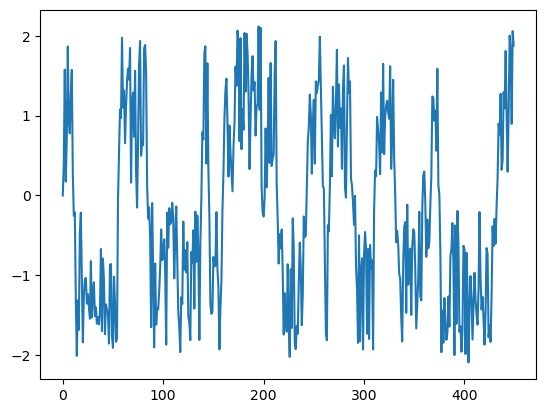

In [176]:
n = 450
rng = np.random.default_rng(seed = 40)
eps = rng.uniform(low = -1.0, high = 1.0, size = n) 

y_sim = np.full(n, 0, dtype = float) 
for i in range(1, n):
    y_sim[i] = ((2*y_sim[i-1])/(1 + 0.8 * (y_sim[i-1] ** 2))) + eps[i]

plt.plot(y_sim)
plt.show()

This dataset is generated as $y_t = g(y_{t-1}) + \epsilon_t$ where $g(x) := 2x/(1 + 0.8 x^2)$. The function $g$ is plotted below. 

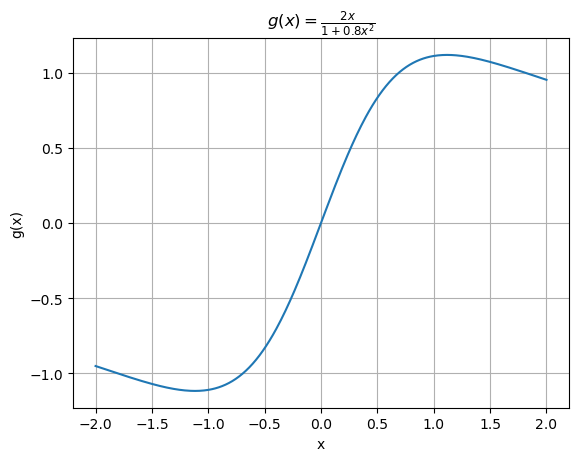

In [177]:
def g(x):
    return 2 * x / (1 + 0.8 * x**2)

x_vals = np.linspace(-2, 2, 400)
y_vals = g(x_vals)

# Plot the function
plt.plot(x_vals, y_vals)
plt.title(r'$g(x) = \frac{2x}{1 + 0.8x^2}$')
plt.xlabel('x')
plt.ylabel('g(x)')
plt.grid(True)
plt.show()

We will fit the model (below $x_t = y_{t-1}$)
\begin{equation*}
  \mu_t = \beta_0 + \beta_1 x_t + \beta_2 (x_t - c_1)_+ + \dots +
  \beta_{k+1} (x_t - c_k)_+. 
\end{equation*}
This model is represented by the following class (this is the same function as the piecewise linear trend model). 


In [178]:
class PiecewiseLinearModel(nn.Module):
    def __init__(self, knots_init, beta_init):
        super().__init__()
        self.num_knots = len(knots_init)
        self.beta = nn.Parameter(torch.tensor(beta_init, dtype=torch.float32)) 
        self.knots = nn.Parameter(torch.tensor(knots_init, dtype=torch.float32))

    def forward(self, x):
        knots_sorted, _ = torch.sort(self.knots)
        out = self.beta[0] + self.beta[1] * x
        for j in range(self.num_knots):
            out += self.beta[j + 2] * torch.relu(x - knots_sorted[j])
        return out

We create tensors for $x$ and $y$ below. 

In [179]:
y_reg = y_sim[1:]
x_reg = y_sim[0:(n-1)]

y_torch = torch.tensor(y_reg, dtype = torch.float32).unsqueeze(1)
x_torch = torch.tensor(x_reg, dtype = torch.float32).unsqueeze(1)

Below we find initial values for $c_1, \dots, c_k$ and $\beta_0, \beta_1, \dots, \beta_{k+1}$. 

In [180]:
k = 6
quantile_levels = np.linspace(1/(k+1), k/(k+1), k)
knots_init = np.quantile(x_reg, quantile_levels)

n_reg = len(y_reg)
X = np.column_stack([np.ones(n_reg), x_reg])
for j in range(k):
    xc = ((x_reg > knots_init[j]).astype(float))*(x_reg - knots_init[j])  
    X = np.column_stack([X, xc])
md_init = sm.OLS(y_reg, X).fit()
beta_init = md_init.params
print(knots_init)
print(beta_init)

[-1.54280223 -1.02805822 -0.60360061 -0.09440788  0.61283012  1.2719812 ]
[-2.31279716 -0.66056549  0.83205759  0.42017211  0.77300214  0.83540066
 -2.59891684  0.37725608]


Below we fit the model and estimate parameters. 

In [181]:
nar = PiecewiseLinearModel(knots_init = knots_init, beta_init = beta_init)
optimizer = optim.Adam(nar.parameters(), lr = 0.01)
loss_fn = nn.MSELoss()

for epoch in range(10000): 
    optimizer.zero_grad()
    y_pred = nar(x_torch)
    loss = loss_fn(y_pred, y_torch)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0: 
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
#Run this code a few times to be sure of convergence. 

Epoch 0, Loss: 0.3186
Epoch 100, Loss: 0.3166
Epoch 200, Loss: 0.3163
Epoch 300, Loss: 0.3162
Epoch 400, Loss: 0.3161
Epoch 500, Loss: 0.3161
Epoch 600, Loss: 0.3161
Epoch 700, Loss: 0.3161
Epoch 800, Loss: 0.3161
Epoch 900, Loss: 0.3161
Epoch 1000, Loss: 0.3161
Epoch 1100, Loss: 0.3161
Epoch 1200, Loss: 0.3161
Epoch 1300, Loss: 0.3161
Epoch 1400, Loss: 0.3161
Epoch 1500, Loss: 0.3161
Epoch 1600, Loss: 0.3161
Epoch 1700, Loss: 0.3161
Epoch 1800, Loss: 0.3161
Epoch 1900, Loss: 0.3161
Epoch 2000, Loss: 0.3161
Epoch 2100, Loss: 0.3161
Epoch 2200, Loss: 0.3161
Epoch 2300, Loss: 0.3161
Epoch 2400, Loss: 0.3161
Epoch 2500, Loss: 0.3161
Epoch 2600, Loss: 0.3161
Epoch 2700, Loss: 0.3161
Epoch 2800, Loss: 0.3161
Epoch 2900, Loss: 0.3161
Epoch 3000, Loss: 0.3161
Epoch 3100, Loss: 0.3161
Epoch 3200, Loss: 0.3161
Epoch 3300, Loss: 0.3161
Epoch 3400, Loss: 0.3161
Epoch 3500, Loss: 0.3161
Epoch 3600, Loss: 0.3161
Epoch 3700, Loss: 0.3161
Epoch 3800, Loss: 0.3161
Epoch 3900, Loss: 0.3161
Epoch 4000, 

Below we plot the function $g$ and the estimated function $\hat{g}$. 

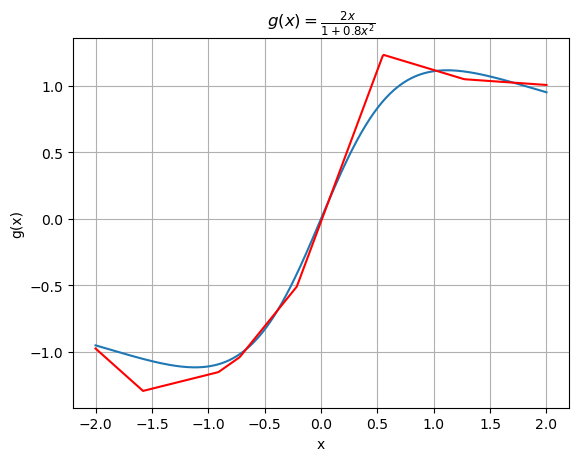

In [182]:
x_vals_torch = torch.tensor(x_vals, dtype = torch.float32).unsqueeze(1)
ghat_nar = nar(x_vals_torch).detach().numpy()

# Plot the function
plt.plot(x_vals, y_vals, label = 'True function g')
plt.plot(x_vals, ghat_nar, color = 'red', label = 'Fitted function by the Nonlinear AR model')
plt.title(r'$g(x) = \frac{2x}{1 + 0.8x^2}$')
plt.xlabel('x')
plt.ylabel('g(x)')
plt.grid(True)
plt.show()

We can also superimpose the fitted linear function by the usual AR(1) model. 

[-0.03280141  0.81247368]


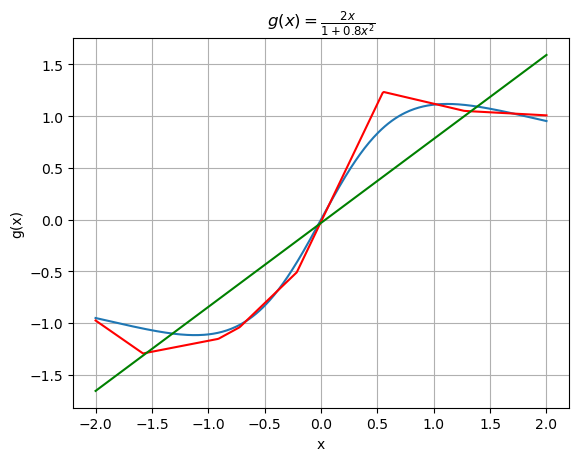

In [183]:
#Function fitted by AR(1)
from statsmodels.tsa.ar_model import AutoReg
ar = AutoReg(y_sim, lags = 1).fit() 
print(ar.params)
ar_vals = ar.params[0] + ar.params[1] * x_vals

# Plot the function
plt.plot(x_vals, y_vals, label = 'True function g')
plt.plot(x_vals, ghat_nar, color = 'red', label = 'Fitted function by the Nonlinear AR model')
plt.plot(x_vals, ar_vals, color = 'green', label = 'Fitted function by the AR(1) model')
plt.title(r'$g(x) = \frac{2x}{1 + 0.8x^2}$')
plt.xlabel('x')
plt.ylabel('g(x)')
plt.grid(True)
plt.show()

We plot these fitted functions on the data $(y_{t-1}, y_t)$. 

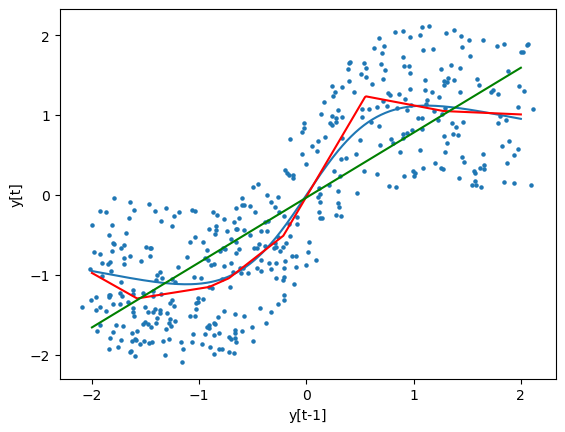

In [184]:
plt.scatter(y_sim[:-1], y_sim[1:], s = 5)
plt.plot(x_vals, y_vals, label = 'True function g')
plt.plot(x_vals, ghat_nar, color = 'red', label = 'Fitted function by the Nonlinear AR model')
plt.plot(x_vals, ar_vals, color = 'green', label = 'Fitted function by the AR(1) model')
plt.xlabel('y[t-1]')
plt.ylabel('y[t]')
plt.show()

Now we obtain predictions for future observations. We obtain predictions with the fitted nonlinear AR(1) model as well as the model where we use the true $g$ function. 

In [185]:
#Predictions: 
#with fitted model
last_val = torch.tensor([[y_sim[-1]]], dtype = torch.float32)
future_preds = []
k_future = 100
for _ in range(k_future):
    next_val = nar(last_val)
    future_preds.append(next_val.item())
    last_val = next_val.detach()
future_preds_array = np.array(future_preds)

#with actual g
actual_preds = []
for _ in range(k_future):
    next_val = ((2*last_val)/(1 + 0.8 * (last_val ** 2)))
    actual_preds.append(next_val.item())
    last_val = next_val.detach()
actual_preds_array = np.array(actual_preds)


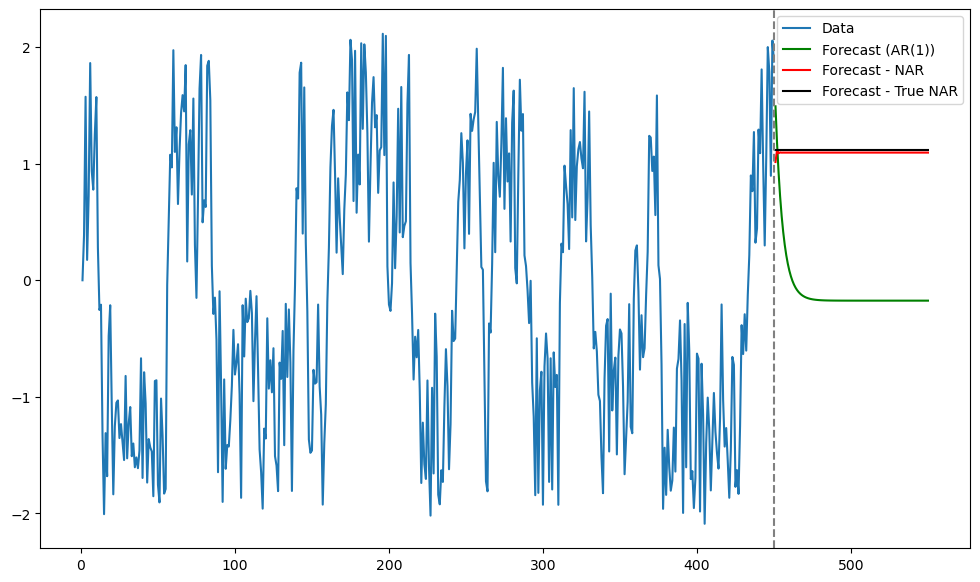

In [186]:
n_y = len(y_sim)
tme = range(1, n_y+1)
tme_future = range(n_y+1, n_y+k_future+1)
fcast = ar.get_prediction(start = n_y, end = n_y+k_future-1).predicted_mean
plt.figure(figsize = (12, 7))
plt.plot(tme, y_sim, label = 'Data')
plt.plot(tme_future, fcast, label = 'Forecast (AR(1))', color = 'green')
plt.plot(tme_future, future_preds_array, label = 'Forecast - NAR', color = 'red')
plt.plot(tme_future, actual_preds_array, label = 'Forecast - True NAR', color = 'black')
plt.axvline(x=n_y, color='gray', linestyle='--')
plt.legend()
plt.show()

It is clear that the predictions obtained by the NAR(1) model are very close to those obtained by using the true $g$ function. Also these predictions are quite different from the predictions of the linear AR(1) model. 

## Example Two

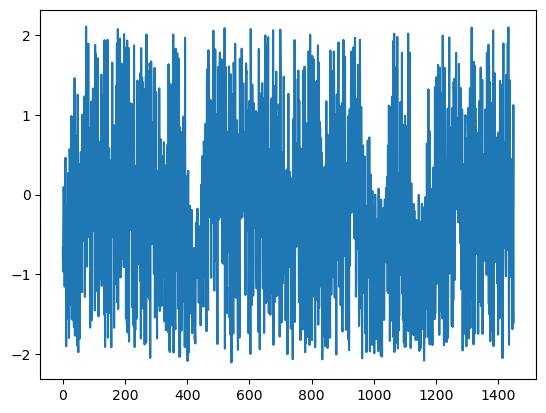

In [187]:
n = 1450
rng = np.random.default_rng(seed = 40)
eps = rng.uniform(low = -1.0, high = 1.0, size = n) 

truelag = 5
y_sim = np.full(n, 0, dtype = float) 
y_sim[:(truelag - 1)] = rng.uniform(low = -1, high = 1, size = truelag - 1)
for i in range(truelag, n):
    y_sim[i] = ((2*y_sim[i-truelag])/(1 + 0.8 * (y_sim[i-truelag] ** 2))) + eps[i]

plt.plot(y_sim)
plt.show()

We will use the single hidden layer neural network model with $p = 5$ for this data. 

In [188]:
class SingleHiddenLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.W = nn.Linear(input_dim, hidden_dim)
        self.beta = nn.Linear(hidden_dim, 1)
    def forward(self, x): 
        s = self.W(x) 
        #r = torch.sigmoid(s)
        r = torch.relu(s)
        #r = torch.tanh(s)
        mu = self.beta(r)
        return mu.squeeze()

In [189]:
torch.manual_seed(3)

#Create x's and y's from the data (x is simply the lagged values). Also conversion to tensors. 
p = truelag
y = torch.tensor(y_sim, dtype = torch.float32)
n = len(y)
x_list = []
y_list = []
for t in range(p, n):
    x_list.append(y[t-p : t]) #(y_{t-1}, \dots, y_{t-p})
    y_list.append(y[t]) #y_t
x_data = torch.stack(x_list) #shape: (n-p, p)
y_data = torch.stack(y_list) #shape: (n-p,)

The model is fit in the following way. 

In [190]:
k = 6
nar_model = SingleHiddenLayerNN(input_dim=p, hidden_dim=k)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(nar_model.parameters(), lr = 0.01)

num_epochs = 10000
for epoch in range(num_epochs): 
    optimizer.zero_grad()
    mu_pred = nar_model(x_data)
    loss = loss_fn(mu_pred, y_data)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item(): .6f}")

Epoch 0, Loss:  0.957468
Epoch 200, Loss:  0.416492
Epoch 400, Loss:  0.389080
Epoch 600, Loss:  0.338375
Epoch 800, Loss:  0.337272
Epoch 1000, Loss:  0.336349
Epoch 1200, Loss:  0.335058
Epoch 1400, Loss:  0.334102
Epoch 1600, Loss:  0.332753
Epoch 1800, Loss:  0.332221
Epoch 2000, Loss:  0.331874
Epoch 2200, Loss:  0.331638
Epoch 2400, Loss:  0.331228
Epoch 2600, Loss:  0.330996
Epoch 2800, Loss:  0.330879
Epoch 3000, Loss:  0.330815
Epoch 3200, Loss:  0.330808
Epoch 3400, Loss:  0.330771
Epoch 3600, Loss:  0.330748
Epoch 3800, Loss:  0.330757
Epoch 4000, Loss:  0.330715
Epoch 4200, Loss:  0.330756
Epoch 4400, Loss:  0.330634
Epoch 4600, Loss:  0.330613
Epoch 4800, Loss:  0.330622
Epoch 5000, Loss:  0.330626
Epoch 5200, Loss:  0.330600
Epoch 5400, Loss:  0.330623
Epoch 5600, Loss:  0.330591
Epoch 5800, Loss:  0.330611
Epoch 6000, Loss:  0.330607
Epoch 6200, Loss:  0.330614
Epoch 6400, Loss:  0.330647
Epoch 6600, Loss:  0.330610
Epoch 6800, Loss:  0.330644
Epoch 7000, Loss:  0.330621

Next we obtain predictions. 

In [191]:
#Predictions
nar_model.eval()
predictions = []
k_future = 40
current_input = y[-p:]
for i in range(k_future):
    with torch.no_grad():
        mu = nar_model(current_input.unsqueeze(0))
    predictions.append(mu.item())
    current_input = torch.cat([current_input[1:], mu.unsqueeze(0)])
predictions = np.array(predictions)


In [192]:
current_input = y[-p:]
print(y)
print(current_input)
print(current_input[0])
print(current_input[0].detach().numpy())

tensor([-0.6649, -0.9638,  0.0533,  ..., -0.1717,  1.1205, -1.6019])
tensor([-1.6860, -0.2503, -0.1717,  1.1205, -1.6019])
tensor(-1.6860)
-1.6860132


For comparison, here are the predictions with the true $g$. 

In [193]:
#Actual predictions using the true function: 
actual_predictions = []
current_input = y[-p:]
for i in range(k_future):
    lastval = current_input[0]
    next_val = ((2*lastval)/(1 + 0.8 * (lastval ** 2)))
    actual_predictions.append(next_val)
    current_input = np.concatenate([current_input[1:], np.array([next_val])])
actual_predictions = np.array(actual_predictions)


Again for comparison, here are the predictions by the linear AR($p$) model with $p = 5$. 

In [194]:
ar = AutoReg(y_sim, lags = p).fit() 
n_y = len(y_sim)
tme = range(1, n_y+1)
tme_future = range(n_y+1, n_y+k_future+1)
fcast = ar.get_prediction(start = n_y, end = n_y+k_future-1).predicted_mean

Below are the predictions by the three models (along with the observed data). 

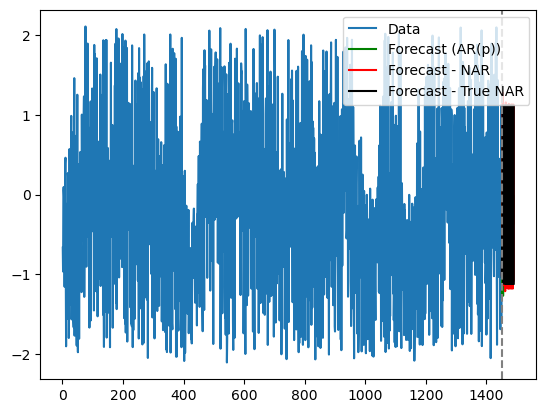

In [195]:
n_y = len(y_sim)
tme = range(1, n_y+1)
tme_future = range(n_y+1, n_y+k_future+1)
plt.plot(tme, y_sim, label = 'Data')
plt.plot(tme_future, fcast, label = 'Forecast (AR(p))', color = 'green')
plt.plot(tme_future, predictions, label = 'Forecast - NAR', color = 'red')
plt.plot(tme_future, actual_predictions, label = 'Forecast - True NAR', color = 'black')
plt.axvline(x=n_y, color='gray', linestyle='--')
plt.legend()
plt.show()

For better visualization, let us only plot the predictions obtained by the three models. 

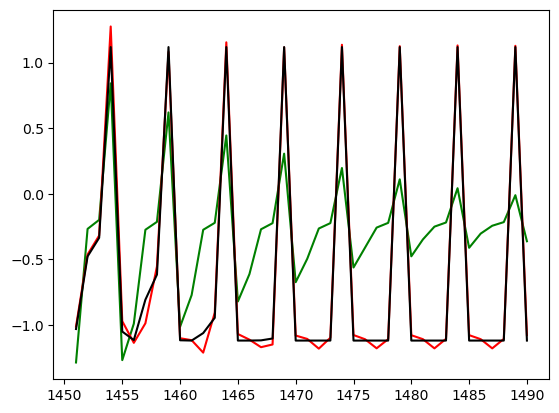

In [197]:
n_y = len(y_sim)
tme = range(1, n_y+1)
tme_future = range(n_y+1, n_y+k_future+1)
plt.plot(tme_future, fcast, label = 'Forecast (AR(p))', color = 'green')
plt.plot(tme_future, predictions, label = 'Forecast - NAR', color = 'red')
plt.plot(tme_future, actual_predictions, label = 'Forecast - True NAR', color = 'black')
#plt.axvline(x=n_y, color='gray', linestyle='--')
#plt.legend()
plt.show()

The closeness of predictions by the NAR($p$) model and AR($p$) model compared with the predictions obtained from the true value of $g$ are computed by the MSEs below. 

In [198]:
mse_ar = np.mean( (actual_predictions - fcast) ** 2) 
mse_NAR = np.mean( (actual_predictions - predictions) ** 2) 
print(mse_ar, mse_NAR, mse_ar/mse_NAR)

0.49578311371259665 0.0031731153461238017 156.24490749075127


Below we plot the data $(y_{t-5}, y_t)$ along with the actual function $g$, and the fitted values by the NAR($p$) model. 

torch.Size([1445])
torch.Size([1445])


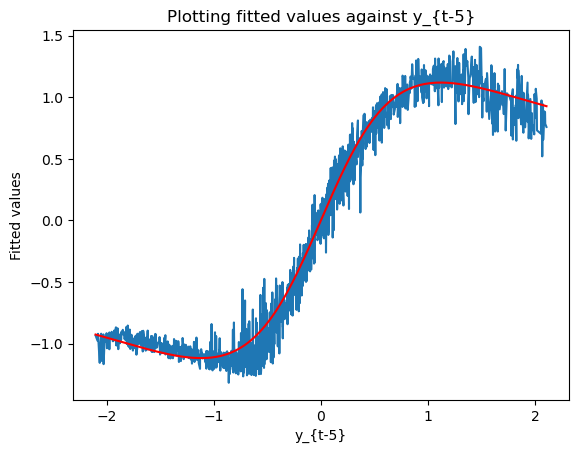

In [199]:
nar_fits = nar_model(x_data)

print(x_data[:,0].shape)
print(nar_fits.shape)

# Sort x_data[:,0] and corresponding nar_fits
sorted_indices = torch.argsort(x_data[:,0])
x_sorted = x_data[:,0][sorted_indices]
nar_fits_sorted = nar_fits[sorted_indices]


def g(x):
    return 2 * x / (1 + 0.8 * x**2)

true_g_vals = g(x_sorted.detach().numpy())


plt.plot(x_sorted.detach().numpy(), nar_fits_sorted.detach().numpy(), label = 'Fitted values') 
plt.plot(x_sorted.detach().numpy(), true_g_vals, color = 'red', label = 'Actual g values')  
plt.title('Plotting fitted values against y_{t-5}')
plt.xlabel('y_{t-5}')
plt.ylabel('Fitted values')
plt.show()


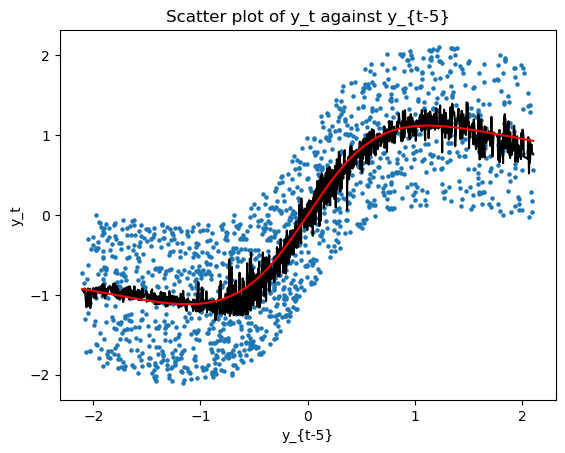

In [200]:
#Plot y_t against y_{t-5}
plt.scatter(x_data[:,0].detach().numpy(), y_data.detach().numpy(), s = 5)
plt.plot(x_sorted.detach().numpy(), nar_fits_sorted.detach().numpy(), label = 'Fitted values', color = 'black') 
plt.plot(x_sorted.detach().numpy(), true_g_vals, color = 'red', label = 'Actual g values')  
plt.xlabel('y_{t-5}')
plt.ylabel('y_t')
plt.title('Scatter plot of y_t against y_{t-5}')
plt.show()